In [1]:
#based on anaylsis from 20140830 ipynb nb.
#Start here once codon stats has been run on the cluster 
#script to process all genes into a single dataframe, run from /Users/aliciadarnell 
#This needs to be run to generate "data" dictionary before I use the following code to analyze results.
import cPickle as pickle
import re
import pandas
import sys
import numpy
from IPython.core.display import clear_output

processedFiles = !ls ../geneStats_*.pickled

df = list()

for File in processedFiles:
    #print File
    temp = pandas.DataFrame.from_dict(  pickle.load( open( File, 'rb' ) ), orient='index' )                            
    sample = re.search( 'geneStats(.*)\.pickled', File ).groups( 1 )[0]                
    print sample
    
    if len( df ) > 0:
        df.append( temp[['totalCountsCds','readDensityPerNt']].rename( columns = {'totalCountsCds': 'counts' + sample, 'readDensityPerNt':'rpnt' + sample} ) )
    else:
        df.append( temp.drop( ['seq','totalCountsTranscript'], axis = 1).rename( columns = {'totalCountsCds': 'counts' + sample, 'readDensityPerNt':'rpnt' + sample} ) )
        
    print File
    sys.stdout.flush()
    
annotations = pandas.load( '../seq_annotation_files/refseq_annotations.pickled' )
df.append( annotations )
        
data = pandas.concat( df, join='inner', axis=1 )

for key in data.keys():
    if key.startswith( 'counts' ):
        data[ key ] = data[ key ].apply( lambda x: numpy.round( x, 0) )                
    if key.startswith( 'rpnt' ):
        data[ key ] = data[ key ].apply( lambda x: numpy.round( x, 2) )                

data['description'] = map( lambda x: x.replace( 'Homo sapiens ', '' ), data['description'] )
    
clear_output()
data['gene'] = map( lambda x: re.search( '\(([\w\-]+)\),', x ).groups()[0], data['description'] )
data = data.reset_index().rename( columns = {'index':'refseqid'} ).set_index( 'gene' )

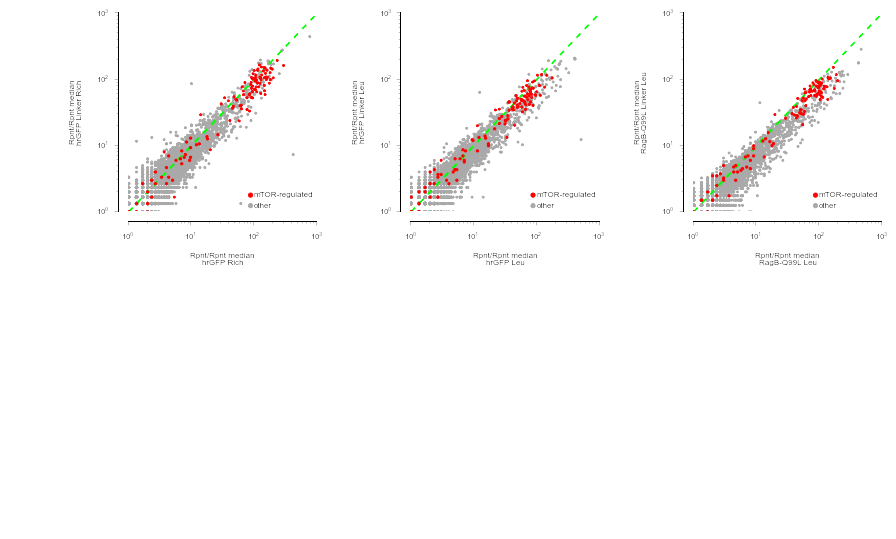

In [22]:
#this code plots differences in translational efficiency in leu vs rich, arg vs rich, and leu vs arg. Outliers may be the pp242 genes, or the top x targets of mTOR inhibition at the level of translational repression.
#goes through x samples one by one and matches it up with the corresponding ySample (I guess this way we only have to iterate through one list, xSamples.
#this needs to be run from a directory containing pp242.csv or change the file path.


from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

xSamples = [ 'hrgfp_rich', 'hrgfp_leu','ragbq99l_leu'
            ]
ySamples = [ 'hrgfp_linker_rich', 'hrgfp_linker_leu','ragbq99l_linker_leu'
            ]

xLabels = [ 'hrGFP Rich','hrGFP Leu','RagB-Q99L Leu']
yLabels = [ 'hrGFP Linker Rich', 'hrGFP Linker Leu', 'RagB-Q99L Linker Leu']

numberOfPlotsPerLine = 3

fig = plt.figure()

pp242_regulated_genes = list( pandas.read_csv( '../seq_annotation_files/pp242_downregulated_genes.csv' )['refseq'] )

for sampleNumber, xSample in enumerate( xSamples ): 
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
        #conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
        
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
            
    xVector = (data[ 'rpnt_' + xSample ][ subset ])
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ] )
    xMedian = numpy.median(xVector)
    yMedian = numpy.median(yVector)
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
    conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'rpnt_' + xSample ][ subset ]) / xMedian
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ]) / yMedian      
    
    ax = fig.add_subplot( len( xSamples) / numberOfPlotsPerLine + 1, numberOfPlotsPerLine, sampleNumber + 1 )    
    ax.scatter( xVector, yVector, marker='.', color = 'red', label='mTOR-regulated', zorder=15 )
    
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
    conditions.append( numpy.logical_not( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) )    
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'rpnt_' + xSample ][ subset ]) / xMedian
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ]) / yMedian   
    
    ax.scatter( xVector, yVector, marker='.', color = 'darkgrey', label='other' )
    
    [ spine.set_position(('outward',10)) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ]    
    
    ax.xaxis.set( ticks_position = 'bottom', major_locator = MaxNLocator(6) )
    ax.yaxis.set( ticks_position = 'left', major_locator = MaxNLocator(6) )
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set( xlabel = 'Rpnt/Rpnt median \n' + xLabels[ sampleNumber ] ,  xlim = (1,1000), ylim=(1,1000) )
    ax.add_line( mlines.Line2D( (1, 1000), (1, 1000), linewidth=2, linestyle='dashed', color='lime', zorder=10 ) )
    ax.set_ylabel( 'Rpnt/Rpnt median \n' +  yLabels[ sampleNumber ] ,ha='center' )
    ax.xaxis.labelpad = 10    
    ax.yaxis.labelpad = 20
    temp = ax.legend(loc='lower right', scatterpoints=1, markerscale=2, handletextsep=0)
    
fig.subplots_adjust( hspace = 0.25, wspace = 0.5 ) #to change the space between figures
fig.set( size_inches = [ 4.5 * numberOfPlotsPerLine, 8 * len( xSamples) / numberOfPlotsPerLine ] );
fig.savefig( '../plots/hrgfp_ragbq99l_polyAvslinker_rpntscatter_mtor.svg')
fig.savefig( '../plots/hrgfp_ragbq99l_polyAvslinker_rpntscatter_mtor.png')
# needed to subtract the x and y medians from each data point since xVector and yVector had slightly different median values